In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib

csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])

csv["contrat_fini"] = (csv["sortie"] != max(csv["sortie"]))
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
#Vire les problèmes liés aux ministres
csv = csv[csv["nombredejours"] > 0]
#Vire les contrats courts de début de législature : sans doute la fin d'un contrat de la législature précédente
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]

In [5]:
#csv = csv[csv["parlementaire"] == "Delphine O"]
csv

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,url_an,id_an,slug,url_nosdeputes,nb_mandats,entree,sortie,nombredejours,contrat_fini,duree_mandat
0,Sophie Errante,Errante,Sophie,F,M. Tristan Boursicot,Tristan,Boursicot,H,https://www.nosdeputes.fr/sophie-errante/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,607193,sophie-errante,https://www.nosdeputes.fr/sophie-errante,1,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,False,373
1,Béatrice Piron,Piron,Béatrice,F,Mme Nadia Laid,Laid,Nadia,F,https://www.nosdeputes.fr/beatrice-piron/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,721844,beatrice-piron,https://www.nosdeputes.fr/beatrice-piron,1,2017-11-06 02:15:21,2018-06-28 22:00:00,234.0,False,373
2,Olivier Becht,Becht,Olivier,H,Mme Mariella Ceriani,Mariella,Ceriani,F,https://www.nosdeputes.fr/olivier-becht/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,642935,olivier-becht,https://www.nosdeputes.fr/olivier-becht,2,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,False,373
3,Sandrine Josso,Josso,Sandrine,F,Mme Florence Sey,Sey,Florence,F,https://www.nosdeputes.fr/sandrine-josso/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,720038,sandrine-josso,https://www.nosdeputes.fr/sandrine-josso,1,2018-06-21 01:15:33,2018-06-28 22:00:00,7.0,False,373
4,Emmanuel Maquet,Maquet,Emmanuel,H,M. Alexis Reichert,Reichert,Alexis,H,https://www.nosdeputes.fr/emmanuel-maquet/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,346054,emmanuel-maquet,https://www.nosdeputes.fr/emmanuel-maquet,1,2017-08-09 01:15:51,2018-06-28 22:00:00,323.0,False,373
6,Marie-Christine Verdier-Jouclas,Verdier-Jouclas,Marie-Christine,F,Mme Chantal Louis-Williatte,Louis-Williatte,Chantal,F,https://www.nosdeputes.fr/marie-christine-verd...,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,721542,marie-christine-verdier-jouclas,https://www.nosdeputes.fr/marie-christine-verd...,1,2017-11-12 02:15:28,2018-06-28 22:00:00,228.0,False,373
7,Guillaume Gouffier-Cha,Gouffier-Cha,Guillaume,H,Mme Paula Doumerg,Doumerg,Paula,F,https://www.nosdeputes.fr/guillaume-gouffier-c...,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,721296,guillaume-gouffier-cha,https://www.nosdeputes.fr/guillaume-gouffier-cha,1,2017-08-10 01:15:38,2018-06-28 22:00:00,322.0,False,373
8,Jean-Philippe Ardouin,Ardouin,Jean-Philippe,H,M. xc9mile Lusignan,Lusignan,xc9mile,H,https://www.nosdeputes.fr/jean-philippe-ardoui...,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,719100,jean-philippe-ardouin,https://www.nosdeputes.fr/jean-philippe-ardouin,1,2018-06-13 01:15:30,2018-06-15 01:15:32,2.0,True,373
9,Charles de Courson,Courson (de),Charles,H,Mme Catherine Marchand,Catherine,Marchand,F,https://www.nosdeputes.fr/charles-de-courson/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,942,charles-de-courson,https://www.nosdeputes.fr/charles-de-courson,3,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,False,373
11,Émilie Bonnivard,Bonnivard,Émilie,F,M. Luigi Gallo,Gallo,Luigi,H,https://www.nosdeputes.fr/emilie-bonnivard/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,http://www2.assemblee-nationale.fr/deputes/fic...,721410,emilie-bonnivard,https://www.nosdeputes.fr/emilie-bonnivard,2,2017-11-05 02:15:23,2018-01-26 02:15:27,82.0,True,373


## Le nombre de collaborateurs 

In [6]:
csv.count()['collaborateur']

2981

## Stats sur les collaborateurs


In [23]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
#duree_collaborateurs = duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7]
duree_collaborateurs = duree_collaborateurs.sort_values("contrat_max")#sort_values("contrat le plus long")
#duree_collaborateurs.fillna(1000, inplace=True)
duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

Tri par le contrat max pour faire remonter les parlementaires ne gardent aucun collaborateur sur le long terme : 
**ils n'ont pas de fidèles**

In [8]:
duree_collaborateurs

,parlementaire,groupe_sigle,sexe_parlementaire,contrat_mediane,nb_collaborateurs,duree_mandat,contrat_max,contrat_min,contrat_fini_max,contrat_fini_min,ratio_contrat_mandat
339,Manuéla Kéclard-Mondésir,GDR,F,51.333333,3,66,54.0,50.0,NaN,NaN,0.777778
510,Sylvain Brial,NI,H,54.000000,1,74,54.0,54.0,NaN,NaN,0.729730
36,Antoine Savignat,LR,H,106.000000,1,144,106.0,106.0,NaN,NaN,0.736111
232,Isabelle Muller-Quoy,LREM,F,113.500000,2,148,116.0,111.0,116.0,111.0,0.766892
300,José Evrard,NI,H,101.428571,7,373,154.0,57.0,154.0,57.0,0.271926
416,Olivier Dussopt,NG,H,135.750000,4,186,154.0,81.0,154.0,81.0,0.729839
434,Patrick Vignal,LREM,H,81.666667,12,373,170.0,10.0,90.0,10.0,0.218945
22,Anissa Khedher,LREM,F,78.875000,8,373,170.0,5.0,170.0,5.0,0.211461
382,Michèle Victory,NG,F,169.333333,3,186,170.0,168.0,NaN,NaN,0.910394
109,Claire Guion-Firmin,LR,F,170.000000,2,373,187.0,153.0,187.0,187.0,0.455764


Les fidèles sont représentés par le palier supérieur à droite du graph suivant : ils sont là depuis le début de la législature.

Le second palie devrait être les fidèles des parlementaires suppléant de ministre du gouvernement Philippe 1.

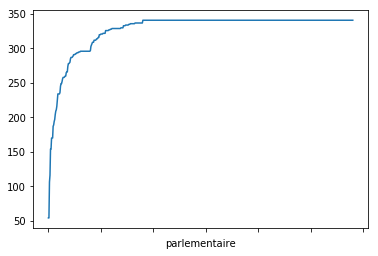

In [9]:
duree_collaborateurs.set_index("parlementaire")["contrat_max"].plot()

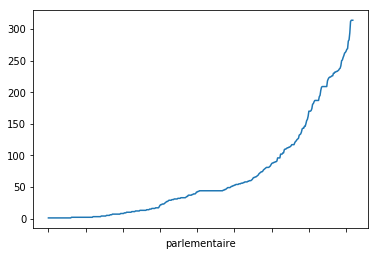

In [10]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

plus de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois

(la période d'essai d'un CDI de collaborateur est de 2 ou 4 mois)

In [11]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 120]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

56.970740103270224

## Par groupe politique

In [21]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,199.609107
LREM,217.571973
MODEM,217.639539
LR,227.961640
GDR,238.278758
LFI,241.306022
NG,243.174270
UAI,245.234740


In [314]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()

In [315]:
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].size().to_frame("nombredecollab")

In [316]:
duree_moy_sexe["nombredecollab"] = nb_collab_sexe["nombredecollab"]

In [87]:
duree_moy_sexe

nombredejours  \
parlementaire              sexe_parlementaire sexe_collaborateur                  
Adrien Morenas             H                  F                      327.000000   
                                              H                      329.000000   
Adrien Quatennens          H                  H                      318.333333   
Adrien Taquet              H                  F                      247.000000   
                                              H                      156.666667   
Agnès Firmin Le Bodo       F                  F                      329.250000   
Agnès Thill                F                  F                      245.000000   
                                              H                      233.000000   
Aina Kuric                 F                  F                      318.500000   
                                              H                      197.333333   
Alain Bruneel              H                  F                      281.333333   
                                              H                      212.000000   
Alain David                H                  F                      309.000000   
                                              H                      135.333333   
Alain Perea                H                  F                      154.500000   
                                              H                      187.250000   
Alain Ramadier             H                  F                      292.000000   
                                              H                      316.500000   
Alain Tourret              H                  F                      341.000000   
                                              H                      247.333333   
Albane Gaillot             F                  F                      180.000000   
                                              H                      165.000000   
Alexandra Louis            F                  F                       75.500000   
                                              H                      265.000000   
Alexandra Valetta Ardisson F                  F                      139.833333   
                                              H                       77.000000   
Alexandre Freschi          H                  F                      111.333333   
                                              H                       43.500000   
Alexandre Holroyd          H                  F                      260.000000   
                                              H                      260.000000   
...                                                                         ...   
Élodie Jacquier-Laforge    F                  F                      312.500000   
                                              H                      182.000000   
Émilie Bonnivard           F                  F                      131.250000   
                                              H                      208.000000   
Émilie Cariou              F                  F                      337.000000   
                                              H                      283.250000   
Émilie Chalas              F                  F                      195.000000   
                                              H                      294.000000   
Émilie Guerel              F                  F                      266.333333   
                                              H                       56.333333   
Éric Alauzet               H                  F                      139.000000   
                                              H                      192.400000   
Éric Bothorel              H                  F                      145.000000   
                                              H                      341.000000   
Éric Ciotti                H                  F                      325.500000   
                                              H                       60.500000   